In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable',
            'conc']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
for name, value in sorted(PARAM.items()):
    print('{} = {}'.format(name, value))

atmpro = mls
band = 3b
commitnumber = d5931a1
conc = 0.0004
dv = 0.005
klin = 0
molecule = co2
ng_adju = [0, 0]
ng_refs = [5, 2]
nv = 200
option_compute_btable = 0
option_compute_ktable = 0
option_wgt_flux = 1
option_wgt_k = 1
ref_pts = [(1, 250), (10, 250)]
tsfc = 294
vmax = 720
vmin = 620
w_diffuse = [(1.66, 1.66, 1.66, 1.66, 1.66), (1.66, 1.66)]
wgt = [(0, 0.6, 0.5, 0.7, 0.8), (0.8, 0.7)]


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

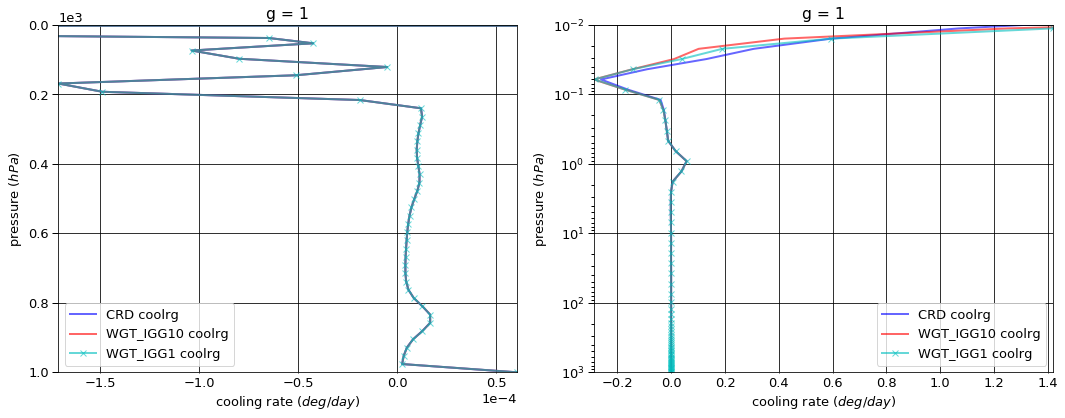

# Figure: cooling rate g-group 2

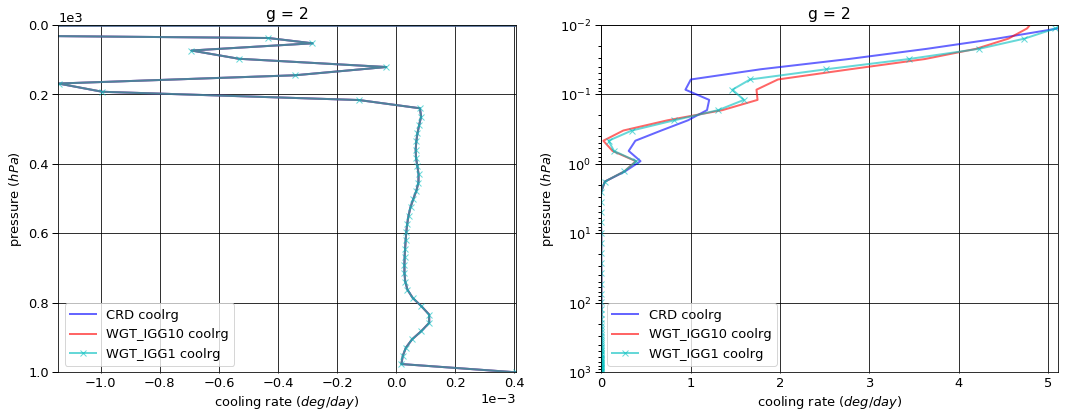

# Figure: cooling rate g-group 3

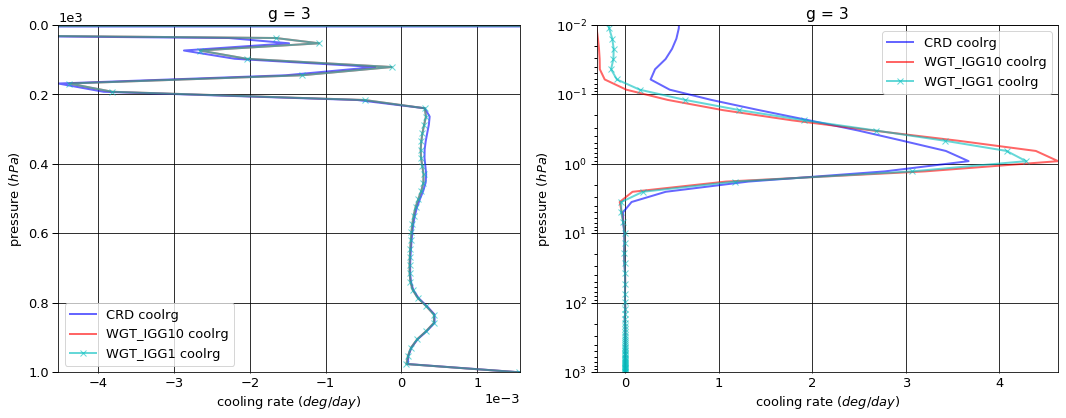

# Figure: cooling rate g-group 4

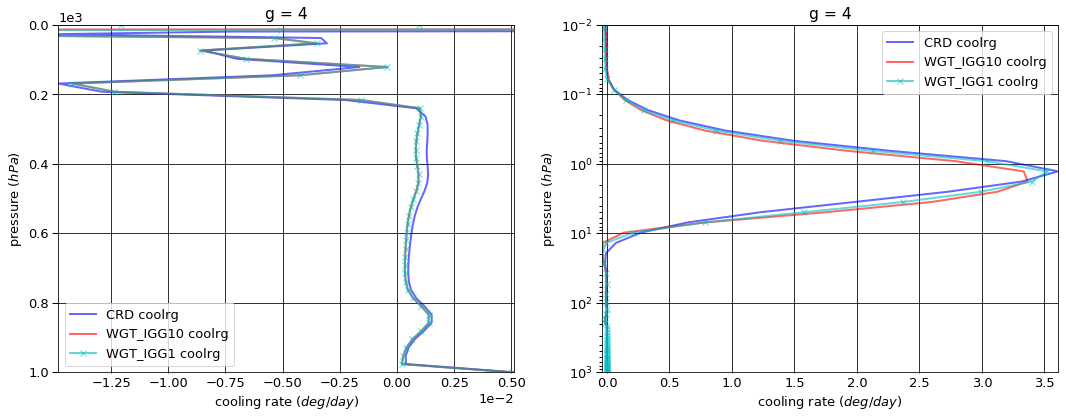

# Figure: cooling rate g-group 5

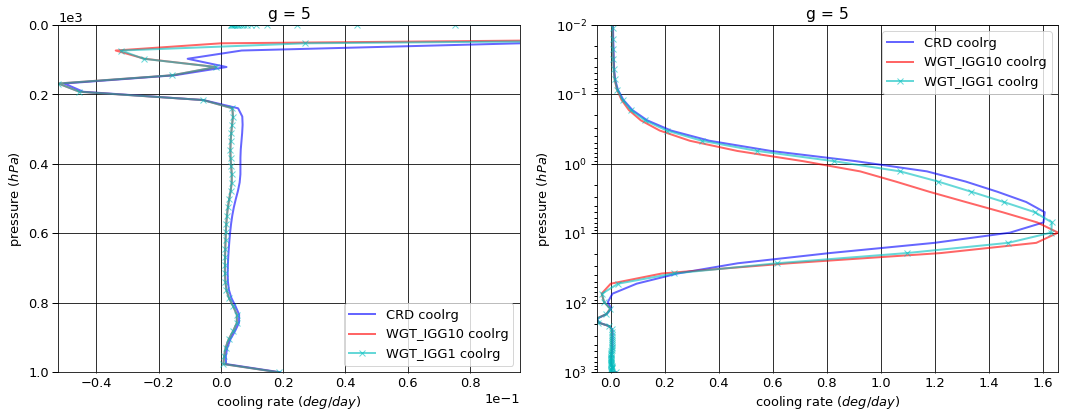

# Figure: cooling rate g-group 6

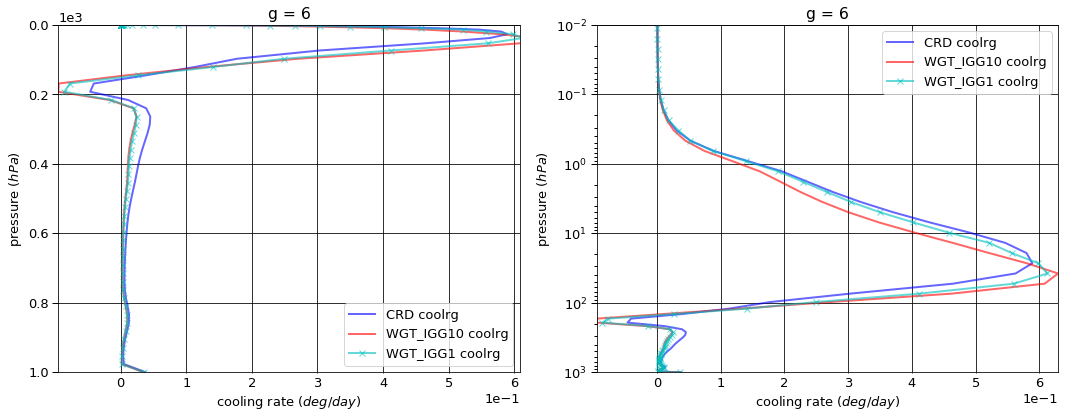

# Figure: cooling rate g-group 7

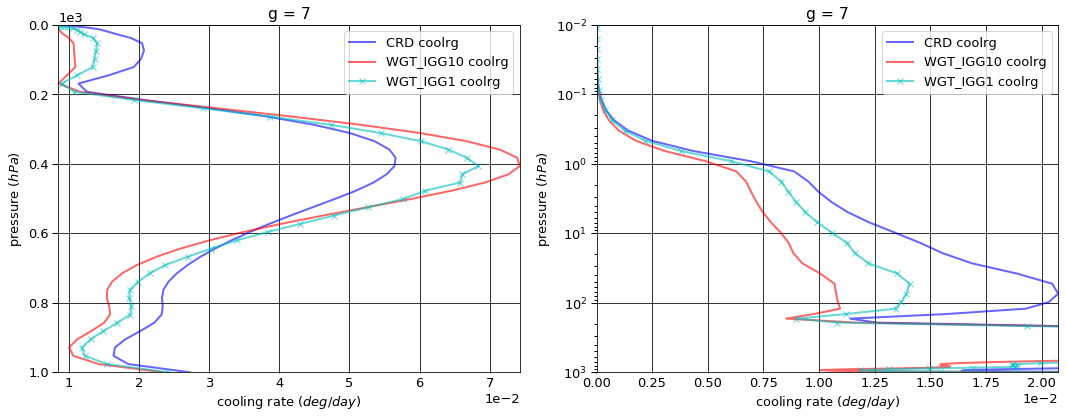

# Figure: cooling rate g-group total

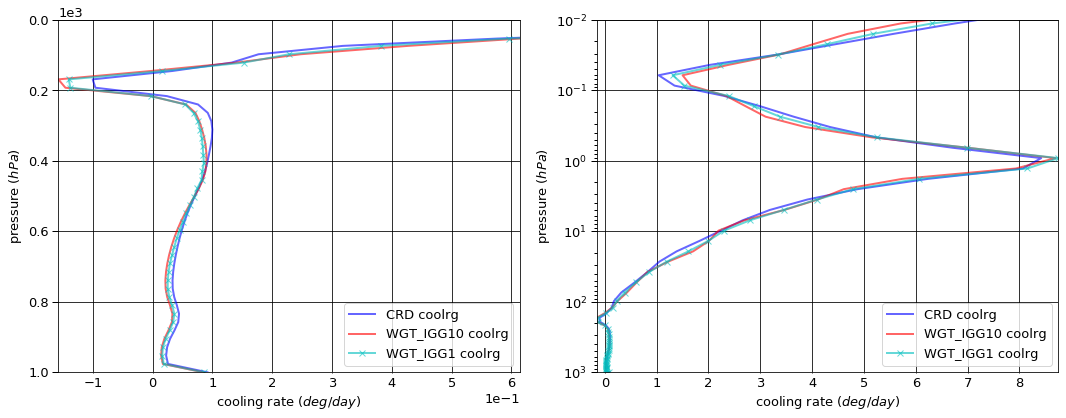

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg     fnetg
g pressure level                                
1 0.0      1      -0.009675   0.000000 -0.009675
  1013.0   76     -0.035280   0.035113 -0.000167
2 0.0      1      -0.091464   0.000000 -0.091464
  1013.0   76     -0.235762   0.234639 -0.001123
3 0.0      1      -0.579290   0.000000 -0.579290
  1013.0   76     -0.903647   0.899270 -0.004377
4 0.0      1      -1.695522   0.000000 -1.695522
  1013.0   76     -2.925008   2.909978 -0.015030
5 0.0      1      -4.429946   0.000000 -4.429946
  1013.0   76    -10.780553  10.723201 -0.057352
6 0.0      1      -7.014606   0.000000 -7.014606
  1013.0   76    -20.697632  20.577135 -0.120497
7 0.0      1      -3.951379   0.000000 -3.951379
  1013.0   76     -8.386956   8.156552 -0.230404


WGT_IGG10


flug       fldg     fnetg
g pressure level                                
1 0.0      1      -0.009713   0.000000 -0.009713
  1013.0   76     -0.035326   0.035159 -0.000168
2 0.0      1      -0.080327   0.000000 -0.080327
  1013.0   76     -0.236024   0.234905 -0.001120
3 0.0      1      -0.593942   0.000000 -0.593942
  1013.0   76     -0.904884   0.900591 -0.004293
4 0.0      1      -1.765956   0.000000 -1.765956
  1013.0   76     -2.930120   2.916218 -0.013902
5 0.0      1      -4.462891   0.000000 -4.462891
  1013.0   76    -10.793487  10.742277 -0.051210
6 0.0      1      -6.726396   0.000000 -6.726396
  1013.0   76    -20.702409  20.603562 -0.098846
7 0.0      1      -3.814040   0.000000 -3.814040
  1013.0   76     -8.362586   8.238462 -0.124124


WGT_IGG1


flug       fldg     fnetg
g pressure level                                
1 0.0      1      -0.009723   0.000000 -0.009723
  1013.0   76     -0.035326   0.035159 -0.000168
2 0.0      1      -0.081628   0.000000 -0.081628
  1013.0   76     -0.236024   0.234905 -0.001120
3 0.0      1      -0.587873   0.000000 -0.587873
  1013.0   76     -0.904884   0.900591 -0.004293
4 0.0      1      -1.758477   0.000000 -1.758477
  1013.0   76     -2.930120   2.916218 -0.013902
5 0.0      1      -4.476882   0.000000 -4.476882
  1013.0   76    -10.793487  10.742277 -0.051210
6 0.0      1      -6.766405   0.000000 -6.766405
  1013.0   76    -20.702409  20.602161 -0.100247
7 0.0      1      -3.873286   0.000000 -3.873286
  1013.0   76     -8.362586   8.221358 -0.141228


WGT_IGG10 - CRD


flug      fldg         fnetg
g pressure level                                  
1 0.0      1     -0.000038  0.000000 -3.754610e-05
  1013.0   76    -0.000046  0.000045 -6.335000e-07
2 0.0      1      0.011137  0.000000  1.113719e-02
  1013.0   76    -0.000263  0.000265  2.890900e-06
3 0.0      1     -0.014652  0.000000 -1.465179e-02
  1013.0   76    -0.001238  0.001321  8.331220e-05
4 0.0      1     -0.070434  0.000000 -7.043380e-02
  1013.0   76    -0.005113  0.006240  1.127789e-03
5 0.0      1     -0.032945  0.000000 -3.294480e-02
  1013.0   76    -0.012934  0.019076  6.141434e-03
6 0.0      1      0.288209  0.000000  2.882095e-01
  1013.0   76    -0.004777  0.026427  2.165120e-02
7 0.0      1      0.137338  0.000000  1.373385e-01
  1013.0   76     0.024370  0.081910  1.062801e-01


WGT_IGG1 - CRD


flug      fldg         fnetg
g pressure level                                  
1 0.0      1     -0.000048  0.000000 -4.781450e-05
  1013.0   76    -0.000046  0.000045 -6.335000e-07
2 0.0      1      0.009836  0.000000  9.835645e-03
  1013.0   76    -0.000263  0.000265  2.890900e-06
3 0.0      1     -0.008583  0.000000 -8.583470e-03
  1013.0   76    -0.001238  0.001321  8.331220e-05
4 0.0      1     -0.062955  0.000000 -6.295490e-02
  1013.0   76    -0.005113  0.006240  1.127789e-03
5 0.0      1     -0.046936  0.000000 -4.693630e-02
  1013.0   76    -0.012934  0.019076  6.141434e-03
6 0.0      1      0.248201  0.000000  2.482008e-01
  1013.0   76    -0.004777  0.025026  2.025001e-02
7 0.0      1      0.078093  0.000000  7.809300e-02
  1013.0   76     0.024370  0.064806  8.917612e-02

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer           
1 0.000312    1      36.635973
  1001.112500 75      0.000060
2 0.000312    1       7.044366
  1001.112500 75      0.000405
3 0.000312    1       0.410241
  1001.112500 75      0.001561
4 0.000312    1      -0.036995
  1001.112500 75      0.005127
5 0.000312    1       0.005130
  1001.112500 75      0.019068
6 0.000312    1       0.000222
  1001.112500 75      0.038098
7 0.000312    1       0.000012
  1001.112500 75      0.027289


WGT_IGG10


coolrg
g pressure    layer           
1 0.000312    1      18.215719
  1001.112500 75      0.000061
2 0.000312    1       4.182781
  1001.112500 75      0.000405
3 0.000312    1      -0.455705
  1001.112500 75      0.001552
4 0.000312    1      -0.028635
  1001.112500 75      0.005024
5 0.000312    1       0.003754
  1001.112500 75      0.018507
6 0.000312    1       0.000221
  1001.112500 75      0.035635
7 0.000312    1       0.000009
  1001.112500 75      0.023538


WGT_IGG1


coolrg
g pressure    layer           
1 0.000312    1      20.063666
  1001.112500 75      0.000061
2 0.000312    1       5.292615
  1001.112500 75      0.000405
3 0.000312    1      -0.310060
  1001.112500 75      0.001552
4 0.000312    1      -0.044139
  1001.112500 75      0.005024
5 0.000312    1       0.003153
  1001.112500 75      0.018507
6 0.000312    1       0.000240
  1001.112500 75      0.035920
7 0.000312    1       0.000016
  1001.112500 75      0.024228


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -1.842025e+01
  1001.112500 75     2.260260e-07
2 0.000312    1     -2.861585e+00
  1001.112500 75     1.855900e-07
3 0.000312    1     -8.659462e-01
  1001.112500 75    -8.991200e-06
4 0.000312    1      8.359762e-03
  1001.112500 75    -1.032562e-04
5 0.000312    1     -1.376239e-03
  1001.112500 75    -5.606830e-04
6 0.000312    1     -1.090490e-06
  1001.112500 75    -2.463114e-03
7 0.000312    1     -2.620569e-06
  1001.112500 75    -3.750761e-03


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -1.657231e+01
  1001.112500 75     2.260260e-07
2 0.000312    1     -1.751751e+00
  1001.112500 75     1.855900e-07
3 0.000312    1     -7.203011e-01
  1001.112500 75    -8.991200e-06
4 0.000312    1     -7.143914e-03
  1001.112500 75    -1.032562e-04
5 0.000312    1     -1.976785e-03
  1001.112500 75    -5.606830e-04
6 0.000312    1      1.777338e-05
  1001.112500 75    -2.177784e-03
7 0.000312    1      4.058881e-06
  1001.112500 75    -3.061362e-03

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-17.771882,0.000000,-17.771882
1013.0,76,-43.964838,43.535888,-0.428950



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-17.453265,0.000000,-17.453265
1013.0,76,-43.964838,43.671173,-0.293664



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-17.554275,0.000000,-17.554275
1013.0,76,-43.964838,43.652668,-0.312169



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,3.186173e-01,0.000000,0.318617
1013.0,76,1.850000e-07,0.135285,0.135286



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,2.176070e-01,0.00000,0.217607
1013.0,76,1.850000e-07,0.11678,0.116781


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,44.058948
1001.112500,75,0.091607



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,21.918143
1001.112500,75,0.084721



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,25.005491
1001.112500,75,0.085695



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-22.140805
1001.112500,75,-0.006886



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-19.053458
1001.112500,75,-0.005912


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.00080,0.000804
2,0.00535,0.005368
3,0.02050,0.020582
4,0.06635,0.066647
5,0.24470,0.245503
6,0.47055,0.470886
7,0.19175,0.190211


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.230874e-17
2,6.648507e-19
3,3.591161e-20
4,1.939749e-21
5,1.047746e-22
6,5.656349e-23
7,3.056898e-24


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.230874e-17,NaN,0.00080,0.000804,0.00080,0.000804,1.0
2,6.648507e-19,0.054015,0.00535,0.005368,0.00615,0.006172,1.0
3,3.591161e-20,0.054015,0.02050,0.020582,0.02665,0.026754,1.0
4,1.939749e-21,0.054015,0.06635,0.066647,0.09300,0.093401,1.0
5,1.047746e-22,0.054015,0.24470,0.245503,0.33770,0.338904,1.0
6,5.656349e-23,0.539859,0.47055,0.470886,0.80825,0.809789,10.0
7,3.056898e-24,0.054044,0.19175,0.190211,1.00000,1.000000,10.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
